In [38]:
# Magic command cho Jupyter
%matplotlib inline

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Thư viện hệ thống và tiện ích
import os
import sys
import json
import math
import time
import pickle
import joblib
import easygui

# Xử lý dữ liệu
import numpy as np
import pandas as pd

# Vẽ biểu đồ
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.offline as pyo
# from plotly.graph_objs import go  # Nếu dùng Plotly nâng cao, có thể bỏ comment dòng này

# Học máy
from sklearn import metrics
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, f1_score,
    classification_report, accuracy_score
)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

# Các thư viện ML nâng cao
import xgboost as xgb
import lightgbm as lgb

# Xử lý tín hiệu và thống kê
import scipy as sp
import scipy.fftpack
from scipy import stats, signal
from scipy.stats import entropy, skew, kurtosis
from scipy.signal import find_peaks, savgol_filter, welch
from numpy import cov

# Phân tích chuỗi thời gian
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.ar_model import AutoReg

# Tkinter GUI
import tkinter as tk
from tkinter import messagebox

# Jupyter settings
from IPython.core.interactiveshell import InteractiveShell

# Cập nhật thư mục làm việc (nếu cần)
current_file_directory = os.getcwd()
os.chdir(current_file_directory)

def model_size_in_bytes(model):
    return len(pickle.dumps(model))

def calculate_auc_multiclass(model, test_features, label_test):
    try:
        predicted_probs = model.predict_proba(test_features)
        return roc_auc_score(label_test, predicted_probs, multi_class='ovr')
    except:
        return None
    
def rotation_matrix_from_vectors(vec1, vec2):
    """Tính ma trận xoay đưa vec1 về vec2"""
    a = vec1 / np.linalg.norm(vec1)
    b = vec2 / np.linalg.norm(vec2)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)

    if s == 0:
        return np.eye(3)  # vectors trùng nhau hoặc ngược hướng

    kmat = np.array([
        [0, -v[2], v[1]],
        [v[2], 0, -v[0]],
        [-v[1], v[0], 0]
    ])

    R = np.eye(3) + kmat + kmat @ kmat * ((1 - c) / (s**2))
    return R

def reorient_acc(df, n_init=2, plot=False):
    df = df[['Acc_X', 'Acc_Y', 'Acc_Z']].copy()
    
    # Bước 1: Ước lượng vector gravity từ n_init mẫu đầu
    gravity_vec = df.iloc[:n_init].mean().values
    gravity_vec = gravity_vec / np.linalg.norm(gravity_vec)

    # Bước 2: Xác định hướng gravity mục tiêu
    target_gravity = np.array([0, -1, 0])  # Acc_Y hướng lên trên

    # Bước 3: Tính ma trận xoay
    R = rotation_matrix_from_vectors(gravity_vec, target_gravity)

    # Bước 4: Xoay toàn bộ dữ liệu
    acc_data = df.values
    acc_rotated = acc_data @ R.T

    df_rotated = pd.DataFrame(acc_rotated, columns=['Acc_X', 'Acc_Y', 'Acc_Z'])

    # Bước 5: Vẽ biểu đồ nếu cần
    if plot:
        plt.figure(figsize=(14, 6))

        plt.subplot(2, 1, 1)
        plt.plot(df['Acc_X'], label='Acc_X', color='red')
        plt.plot(df['Acc_Y'], label='Acc_Y', color='green')
        plt.plot(df['Acc_Z'], label='Acc_Z', color='blue')
        plt.title('🌐 Trước khi xoay hệ trục')
        plt.ylabel('Gia tốc (g)')
        plt.legend(); plt.grid(True)

        plt.subplot(2, 1, 2)
        plt.plot(df_rotated['Acc_X'], label='Acc_X (xoay)', color='red')
        plt.plot(df_rotated['Acc_Y'], label='Acc_Y (xoay)', color='green')
        plt.plot(df_rotated['Acc_Z'], label='Acc_Z (xoay)', color='blue')
        plt.title('🧭 Sau khi xoay về hệ trục chuẩn (Y lên, Z ra trước)')
        plt.xlabel('Time step')
        plt.ylabel('Gia tốc (g)')
        plt.legend(); plt.grid(True)

        plt.tight_layout()
        plt.show()

    return df_rotated


from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
def calculate_metrics(conf_matrix, class_labels):
    # Tính toán TP, FP, FN, TN
    TP = np.diag(conf_matrix)
    FP = np.sum(conf_matrix, axis=0) - TP
    FN = np.sum(conf_matrix, axis=1) - TP
    TN = np.sum(conf_matrix) - (TP + FP + FN)

    # Tính Accuracy, Sensitivity, Specificity cho từng lớp
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    precision = TP / (TP + FP)
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
    accuracy_total = (np.sum(TP) + np.sum(TN)) / (np.sum(TP) + np.sum(FP)+np.sum(TN)+np.sum(FN))
    metrics = []
    for i in range(len(conf_matrix)):
        metrics.append({
            'Activity': class_labels[i],
            'Acc': round(accuracy[i] * 100, 1),
            'Sen': round(sensitivity[i] * 100, 1),
            'Spe': round(specificity[i] * 100, 1),
            'Pre': round(precision[i] * 100, 1),
            'F1': round(f1[i] * 100, 1)
        })

    # Tạo y_true và y_pred từ ma trận nhầm lẫn để tính f1_micro
    y_true_all = []
    y_pred_all = []
    for i in range(len(conf_matrix)):
        for j in range(len(conf_matrix)):
            count = conf_matrix[i, j]
            y_true_all += [i] * count
            y_pred_all += [j] * count

    f1_micro = f1_score(y_true_all, y_pred_all, average='micro', zero_division=0)

    # Tính trung bình các chỉ số (bỏ qua NaN)
    avg_accuracy = np.nanmean(accuracy)
    avg_sensitivity = np.nanmean(sensitivity)
    avg_specificity = np.nanmean(specificity)
    avg_precision = np.nanmean(precision)
    return avg_accuracy, avg_sensitivity, avg_specificity, avg_precision, accuracy_total


def model_size_in_bytes(model):
    return len(pickle.dumps(model))

def calculate_auc_multiclass(model, test_features, label_test):
    try:
        predicted_probs = model.predict_proba(test_features)
        return roc_auc_score(label_test, predicted_probs, multi_class='ovr')
    except:
        return None



In [2]:
# ✅ Hàm xử lý dữ liệu thô
def segment_raw_data(full_data, selected_actions, window_length=151, overlap=0):
    all_windows = {}
    activity_windows = {}
    for volunteer_id in range(1, 31):
        volunteer_data = full_data[volunteer_id - 1][0][0]
        for action in selected_actions:
            field_data = volunteer_data[0][action]
            if len(field_data) == 2:  # ADLs
                for trial in field_data:
                    acc_data = trial[0][:3, :]
                    step = int(window_length * (1 - overlap))
                    num_windows = (acc_data.shape[1] - window_length) // step + 1
                    for i in range(num_windows):
                        start = i * step
                        end = start + window_length
                        window = acc_data[:, start:end]
                        if np.isnan(window).any():
                            continue
                        all_windows.setdefault(action, []).append(window)
            elif len(field_data) == 6:  # Falls
                for trial in field_data:
                    acc_data = trial[0][:3, :]
                    if np.isnan(acc_data).any():
                        continue
                    all_windows.setdefault(action, []).append(acc_data)
    # Convert to DataFrame
    for action, windows in all_windows.items():
        dfs = [pd.DataFrame(w.T, columns=['Acc_X', 'Acc_Y', 'Acc_Z']) for w in windows]
        var_name = f"w_{action}"
        globals()[var_name] = dfs
        activity_windows[var_name] = dfs
        print(f"Raw-{var_name:<20}: {len(dfs)} cửa sổ")
    return activity_windows
# ✅ Hàm xử lý dữ liệu đã phân đoạn
def segment_presegmented_data(acc_data, acc_labels, acc_names, selected_actions):
    action_names = [str(name[0]) for name in acc_names[1]]
    activity_windows = {}
    for i, action in enumerate(action_names, start=1):
        if action not in selected_actions:
            continue
        indices = np.where(acc_labels[:, 0] == i)[0]
        windows = []
        for idx in indices:
            row = acc_data[idx]
            acc_x = row[:151]
            acc_y = row[151:302]
            acc_z = row[302:]
            df = pd.DataFrame({'Acc_X': acc_x, 'Acc_Y': acc_y, 'Acc_Z': acc_z})
            windows.append(df)
        var_name = f"w_{action}"
        globals()[var_name] = windows
        activity_windows[var_name] = windows
        print(f"Segment-{var_name:<20}: {len(windows)} cửa sổ")
    return activity_windows
# ✅ Danh sách các hành động theo từng phương pháp xử lý
# Các hành động cần xử lý từ dữ liệu thô
raw_actions = [
    'Walking', 'Running', 'GoingUpS', 'GoingDownS',
    'FallingForw', 'FallingRight', 'FallingBack', 'HittingObstacle', 'FallingWithPS', 'FallingBackSC', 'Syncope', 'FallingLeft'
]
# Các hành động cần xử lý từ dữ liệu đã phân đoạn
presegmented_actions = ['StandingUpFS', 'StandingUpFL', 'Jumping', 'LyingDownFS', 'SittingDown']
# ✅ Chạy toàn bộ quy trình phân đoạn
# Danh sách các đường dẫn có thể
import os
possible_dirs = [
    'G:/My Drive/NCSHieu/linh cuu hoa/dataset/',
    'D:/NCSHieuServer/My Drive/NCSHieu/linh cuu hoa/dataset/'
]

# Tìm đường dẫn tồn tại đầu tiên
_dir = next((d for d in possible_dirs if os.path.exists(d)), None)
save_ = _dir+'UniMiB-SHAR/backup ket qua/'
# Dữ liệu thô
full_data = scipy.io.loadmat(_dir + 'UniMiB-SHAR/data/full_data.mat')['full_data']
# Dữ liệu đã phân đoạn
acc_data = scipy.io.loadmat(_dir + 'UniMiB-SHAR/data/acc_data.mat')['acc_data']
acc_labels = scipy.io.loadmat(_dir + 'UniMiB-SHAR/data/acc_labels.mat')['acc_labels']
acc_names = scipy.io.loadmat(_dir + 'UniMiB-SHAR/data/acc_names.mat')['acc_names']
# Phân đoạn từ dữ liệu thô
raw_activity_windows = segment_raw_data(full_data, raw_actions)
# Phân đoạn từ dữ liệu đã phân đoạn
presegmented_activity_windows = segment_presegmented_data(acc_data, acc_labels, acc_names, presegmented_actions)
# Gộp tất cả vào 1 từ điển chung
activity_windows = {**raw_activity_windows, **presegmented_activity_windows}
total_windows = sum(len(w) for w in activity_windows.values())
print(f"Total: {total_windows}")

Raw-w_Walking           : 609 cửa sổ
Raw-w_Running           : 567 cửa sổ
Raw-w_GoingUpS          : 204 cửa sổ
Raw-w_GoingDownS        : 206 cửa sổ
Raw-w_FallingForw       : 180 cửa sổ
Raw-w_FallingRight      : 180 cửa sổ
Raw-w_FallingBack       : 180 cửa sổ
Raw-w_HittingObstacle   : 180 cửa sổ
Raw-w_FallingWithPS     : 180 cửa sổ
Raw-w_FallingBackSC     : 180 cửa sổ
Raw-w_Syncope           : 180 cửa sổ
Raw-w_FallingLeft       : 180 cửa sổ
Segment-w_StandingUpFS      : 153 cửa sổ
Segment-w_StandingUpFL      : 216 cửa sổ
Segment-w_Jumping           : 746 cửa sổ
Segment-w_LyingDownFS       : 296 cửa sổ
Segment-w_SittingDown       : 200 cửa sổ
Total: 4637


In [3]:
def detect_peaks_with_plot_3axis(df, g=9.8, threshold=1.5, visualize=True, field_name='Unknown'):
    acc_x = df['Acc_X'].values
    acc_y = df['Acc_Y'].values
    acc_z = df['Acc_Z'].values
    # Tính độ lớn vector gia tốc tại mỗi mẫu
    magnitude = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)
    threshold_val = threshold * g
    # Phát hiện đỉnh: m_t > threshold và m_{t-1} <= threshold
    peaks = np.where((magnitude[1:] > threshold_val) & (magnitude[:-1] <= threshold_val))[0] + 1
    # ✅ In thông tin các đỉnh
    for peak in peaks:
        print(f"🔹 Đỉnh tại vị trí {peak}, độ lớn = {magnitude[peak]:.2f} m/s²")
    # ✅ Vẽ biểu đồ 3 trục (nếu được yêu cầu)
    if visualize:
        x_vals = np.arange(len(df))
        plt.figure(figsize=(12, 4))
        plt.plot(x_vals, acc_x, label='Gia tốc X', color='r')
        plt.plot(x_vals, acc_y, label='Gia tốc Y', color='g')
        plt.plot(x_vals, acc_z, label='Gia tốc Z', color='b')
        for peak in peaks:
            plt.axvline(x=peak, color='k', linestyle='--', alpha=0.7)
        plt.title(f'Đỉnh tại mẫu {peak} (|a| = {magnitude[peak]:.2f} m/s²)')
        plt.xlabel('Số lượng mẫu')
        plt.ylabel('Gia tốc (m/s²)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    return peaks

def extract_peak_segment_with_noise_padding(df,left,right):
    acc_mag = np.sqrt(df['Acc_X']**2 + df['Acc_Y']**2 + df['Acc_Z']**2)
    peak_idx = acc_mag.idxmax()

    left_size = left
    right_size = right

    start_idx = peak_idx - left_size
    end_idx = peak_idx + right_size + 1

    left_part = df.iloc[max(0, start_idx):peak_idx]
    peak_row = df.iloc[[peak_idx]]
    right_part = df.iloc[peak_idx + 1:min(len(df), end_idx)]

    def generate_noisy_samples(ref_df, num_samples):
        mean = ref_df.mean(numeric_only=True)
        numeric_cols = mean.index
        noise = np.random.uniform(-0.05*9.80665, 0.05*9.80665, size=(num_samples, len(numeric_cols)))
        samples = mean.values + noise
        gen_df = pd.DataFrame(samples, columns=numeric_cols)

        # Xử lý cột không phải số (vd: timestamp)
        for col in df.columns:
            if col not in numeric_cols:
                gen_df[col] = np.nan
        return gen_df[df.columns]

    # Padding trái
    if len(left_part) < left_size:
        pad_count = left_size - len(left_part)
        pad_data = generate_noisy_samples(df.iloc[:2], pad_count)
        left_part = pd.concat([pad_data, left_part], ignore_index=True)

    # Padding phải
    if len(right_part) < right_size:
        pad_count = right_size - len(right_part)
        pad_data = generate_noisy_samples(df.iloc[-2:], pad_count)
        right_part = pd.concat([right_part, pad_data], ignore_index=True)

    segment = pd.concat([left_part, peak_row, right_part], ignore_index=True)

    return segment

Tìm đỉnh và cắt cửa sổ w_activity

In [6]:
def extract_event_centered_windows(df, g=9.8, left_size=40, right_size=18, threshold=1.5, visualize=True, field_name='Unknown'):
    """
    Phát hiện đỉnh và trích xuất các cửa sổ 'left_size' và 'right_size' xoay quanh đỉnh. 
    Có thể vẽ đồ thị minh họa nếu visualize=True.
    Parameters:
        df (pd.DataFrame): Dữ liệu gia tốc có các cột 'Acc_X', 'Acc_Y', 'Acc_Z'
        g (float): Gia tốc trọng trường (m/s^2)
        left_size (int): Số mẫu bên trái đỉnh
        right_size (int): Số mẫu bên phải đỉnh
        threshold (float): Ngưỡng phát hiện đỉnh (so với g)
        visualize (bool): Có vẽ biểu đồ minh họa hay không
    Returns:
        List[pd.DataFrame]: Danh sách các cửa sổ được trích xuất
    """
    acc_x = df['Acc_X'].values
    acc_y = df['Acc_Y'].values
    acc_z = df['Acc_Z'].values
    # Tính độ lớn vector gia tốc tại mỗi thời điểm
    magnitude = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)
    # Ngưỡng tuyệt đối (m/s^2)
    threshold_val = threshold * g
    # Phát hiện đỉnh: m_t > threshold và m_{t-1} < threshold
    peaks = np.where((magnitude[1:] > threshold_val) & (magnitude[:-1] <= threshold_val))[0] + 1
    extracted_windows = []
    for peak in peaks:
        start = peak - left_size
        end = peak + right_size
        if start >= 0 and end <= len(df):
            window_df = df.iloc[start:end].reset_index(drop=True)
            extracted_windows.append(window_df)
            # ✅ In vị trí và giá trị của đỉnh
            print(f"🔹 Đỉnh tại vị trí {peak}, độ lớn = {magnitude[peak]:.2f} m/s²")
            # ✅ Vẽ biểu đồ cho mỗi đỉnh
            if visualize:
                x_vals = np.arange(start, end)
                plt.figure(figsize=(12, 4))
                plt.plot(x_vals, acc_x[start:end], label='Gia tốc X', color='r')
                plt.plot(x_vals, acc_y[start:end], label='Gia tốc Y', color='g')
                plt.plot(x_vals, acc_z[start:end], label='Gia tốc Z', color='b')
                plt.axvline(x=peak, color='k', linestyle='--', label='Đỉnh sự kiện')
                plt.title(f'Đỉnh tại mẫu {peak} (|a| = {magnitude[peak]:.2f} m/s²)')
                plt.xlabel('Số lượng mẫu')
                plt.ylabel('Gia tốc (m/s²)')
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()
    return extracted_windows
def cut_data_around_peak(data, left_size, right_size):
    # Tính giá trị tuyệt đối lớn nhất trên từng hàng của 3 trục
    abs_max = data[['Acc_X', 'Acc_Y', 'Acc_Z']].abs().max(axis=1)
    
    # Tìm chỉ số của giá trị lớn nhất
    peak_index = abs_max.idxmax()
    
    # Xác định khoảng cắt
    start = max(0, peak_index - left_size)
    end = min(len(data), peak_index + right_size + 1)  # +1 vì slicing không bao gồm end
    
    # Trích xuất dữ liệu
    return data.iloc[start:end].reset_index(drop=True)

def normalize_orientation(acc_df):
    acc_data = acc_df[['Acc_X', 'Acc_Y', 'Acc_Z']].to_numpy()

    # --- Estimate gravity from first 10 samples
    g_measured = np.mean(acc_data[:10], axis=0)
    g_measured = g_measured / np.linalg.norm(g_measured)

    y_measured = -g_measured

    # Xử lý nếu g_measured gần song song với x_temp
    if np.abs(np.dot(y_measured, [1, 0, 0])) > 0.9:
        x_temp = np.array([0.0, 1.0, 0.0])
    else:
        x_temp = np.array([1.0, 0.0, 0.0])

    z_measured = np.cross(y_measured, x_temp)
    z_measured = z_measured / np.linalg.norm(z_measured)
    x_measured = np.cross(y_measured, z_measured)
    x_measured = x_measured / np.linalg.norm(x_measured)

    R_measured = np.stack([x_measured, y_measured, z_measured], axis=1)
    R_target = np.eye(3)

    R = R_target @ R_measured.T
    acc_rotated = acc_data @ R.T

    return pd.DataFrame(acc_rotated, columns=['Acc_X', 'Acc_Y', 'Acc_Z'])


Trích xuất cửa sổ 'w_activity_cut' sau khi tìm đỉnh và cắt cửa sổ 'w_activity'

In [7]:
w_StandingUpFS_cut = []; w_StandingUpFL_cut = []; w_LyingDownFS_cut = []; w_SittingDown_cut = []
def process_action_windows(w_action, action_name,filter):
    w_action_cut = []
    for i, window_df in enumerate(w_action):
        print(f"\n🔍 {action_name} – xử lý cửa sổ #{i}")
        cut_windows = extract_event_centered_windows(window_df, visualize=False, field_name=f'{action_name}#{i}')
        
        if len(cut_windows) == 1:
            # Gọi hàm xử lý đỉnh với DataFrame duy nhất
            segment = extract_peak_segment_with_noise_padding(cut_windows[0], 75, 75)
            if filter == 1:
                segment = normalize_orientation (segment)
            w_action_cut.append(segment)
        else:
            print(f"⚠️ Bỏ qua vì có {len(cut_windows)} đỉnh")
    return w_action_cut

# Ví dụ:
w_StandingUpFS_cut = process_action_windows(w_StandingUpFS, 'StandingUpFS',0)
w_StandingUpFL_cut = process_action_windows(w_StandingUpFL, 'StandingUpFL',0)
w_LyingDownFS_cut = process_action_windows(w_LyingDownFS, 'LyingDownFS',1)
w_SittingDown_cut = process_action_windows(w_SittingDown, 'SittingDown',0)
print(f"\n✅ Tổng số cửa sổ w_StandingUpFS_cut sau khi trích xuất từ đỉnh: {len(w_StandingUpFS_cut)}")
print(f"\n✅ Tổng số cửa sổ w_StandingUpFL_cut sau khi trích xuất từ đỉnh: {len(w_StandingUpFL_cut)}")
print(f"\n✅ Tổng số cửa sổ w_LyingDownFS_cut sau khi trích xuất từ đỉnh: {len(w_LyingDownFS_cut)}")
print(f"\n✅ Tổng số cửa sổ w_SittingDown_cut sau khi trích xuất từ đỉnh: {len(w_SittingDown_cut)}")



🔍 StandingUpFS – xử lý cửa sổ #0
🔹 Đỉnh tại vị trí 75, độ lớn = 17.19 m/s²

🔍 StandingUpFS – xử lý cửa sổ #1
🔹 Đỉnh tại vị trí 75, độ lớn = 21.56 m/s²

🔍 StandingUpFS – xử lý cửa sổ #2
🔹 Đỉnh tại vị trí 75, độ lớn = 18.59 m/s²

🔍 StandingUpFS – xử lý cửa sổ #3
🔹 Đỉnh tại vị trí 75, độ lớn = 20.09 m/s²

🔍 StandingUpFS – xử lý cửa sổ #4
🔹 Đỉnh tại vị trí 75, độ lớn = 22.43 m/s²

🔍 StandingUpFS – xử lý cửa sổ #5
🔹 Đỉnh tại vị trí 75, độ lớn = 20.30 m/s²

🔍 StandingUpFS – xử lý cửa sổ #6
🔹 Đỉnh tại vị trí 75, độ lớn = 18.21 m/s²

🔍 StandingUpFS – xử lý cửa sổ #7
🔹 Đỉnh tại vị trí 75, độ lớn = 21.28 m/s²

🔍 StandingUpFS – xử lý cửa sổ #8
🔹 Đỉnh tại vị trí 75, độ lớn = 20.37 m/s²

🔍 StandingUpFS – xử lý cửa sổ #9
🔹 Đỉnh tại vị trí 75, độ lớn = 18.89 m/s²

🔍 StandingUpFS – xử lý cửa sổ #10
🔹 Đỉnh tại vị trí 75, độ lớn = 15.00 m/s²

🔍 StandingUpFS – xử lý cửa sổ #11
🔹 Đỉnh tại vị trí 75, độ lớn = 15.36 m/s²

🔍 StandingUpFS – xử lý cửa sổ #12
🔹 Đỉnh tại vị trí 75, độ lớn = 18.19 m/s²

🔍 Standi

In [8]:
#xử lý các file ngã
w_FallingForw_cut = []
for act in w_FallingForw:
    w_data = extract_peak_segment_with_noise_padding(act,249,50)
    w_data = normalize_orientation (w_data)
    w_FallingForw_cut.append(w_data)

#xử lý các file ngã
w_FallingRight_cut = []
for act in w_FallingRight:
    w_data = extract_peak_segment_with_noise_padding(act,249,50)
    w_data = normalize_orientation (w_data)
    w_FallingRight_cut.append(w_data)

w_FallingBack_cut=[]
for act in w_FallingBack:
    w_data = extract_peak_segment_with_noise_padding(act,249,50)
    w_data = normalize_orientation (w_data)
    w_FallingBack_cut.append(w_data)
    
w_HittingObstacle_cut =[]
for act in w_HittingObstacle:
    w_data = extract_peak_segment_with_noise_padding(act,249,50)
    w_data = normalize_orientation (w_data)
    w_HittingObstacle_cut.append(w_data)
    
w_FallingWithPS_cut  =[]
for act in w_FallingWithPS:
    w_data = extract_peak_segment_with_noise_padding(act,249,50)
    # w_data = normalize_orientation (w_data)
    w_FallingWithPS_cut.append(w_data)

w_FallingBackSC_cut = []
for act in w_FallingBackSC:
    w_data = extract_peak_segment_with_noise_padding(act,249,50)
    # w_data = normalize_orientation (w_data)
    w_FallingBackSC_cut.append(w_data)
    
w_Syncope_cut = []
for act in w_Syncope:
    w_data = extract_peak_segment_with_noise_padding(act,249,50)
    w_data = normalize_orientation (w_data)
    w_Syncope_cut.append(w_data)
    
w_FallingLeft_cut = []
for act in w_FallingLeft:
    w_data = extract_peak_segment_with_noise_padding(act,249,50)
    w_data = normalize_orientation (w_data)
    w_FallingLeft_cut.append(w_data)

In [9]:
#xu ly them
w_Walking_pre =[]
for act in w_Walking:
    w_data = normalize_orientation (act)
    w_Walking_pre.append(w_data)
w_Running_pre =[]
for act in w_Running:
    w_data = normalize_orientation (act)
    w_Running_pre.append(w_data)

w_GoingUpS_pre =[]
for act in w_GoingUpS:
    w_data = normalize_orientation (act)
    w_GoingUpS_pre.append(w_data)
    
w_GoingDownS_pre =[]
for act in w_GoingDownS:
    w_data = normalize_orientation (act)
    w_GoingDownS_pre.append(w_data)
    
w_Jumping_pre =[]
for act in w_Jumping:
    w_data = normalize_orientation (act)
    w_Jumping_pre.append(w_data)

Tạo chuỗi dữ liệu và nhãn dùng để train và test

In [9]:
from sklearn.model_selection import train_test_split # Hàm chia ngẫu nhiên tương ứng
RateTrain = 0.6;var_random=30

test_StandingUpFS, train_StandingUpFS = train_test_split(w_StandingUpFS_cut, test_size=RateTrain,random_state=var_random)
print('train_StandingUpFS:', len(train_StandingUpFS))
print('test_StandingUpFS:', len(test_StandingUpFS))

test_StandingUpFL, train_StandingUpFL = train_test_split(w_StandingUpFL_cut, test_size=RateTrain,random_state=var_random)
print('train_StandingUpFL:', len(train_StandingUpFL))
print('test_StandingUpFL:', len(test_StandingUpFL))

test_Walking, train_Walking = train_test_split(w_Walking_pre, test_size=RateTrain,random_state=var_random)
print('train_Walking:', len(train_Walking))
print('test_Walking:', len(test_Walking))

test_Running, train_Running = train_test_split(w_Running_pre, test_size=RateTrain,random_state=var_random)
print('train_Running:', len(train_Running))
print('test_Running:', len(test_Running))

test_GoingUpS, train_GoingUpS = train_test_split(w_GoingUpS, test_size=RateTrain,random_state=var_random)
print('train_GoingUpS:', len(train_GoingUpS))
print('test_GoingUpS:', len(test_GoingUpS))

test_Jumping, train_Jumping = train_test_split(w_Jumping_pre, test_size=RateTrain,random_state=var_random)
print('train_Jumping:', len(train_Jumping))
print('test_Jumping:', len(test_Jumping))

test_GoingDownS, train_GoingDownS = train_test_split(w_GoingDownS_pre, test_size=RateTrain,random_state=var_random)
print('train_GoingDownS:', len(train_GoingDownS))
print('test_GoingDownS:', len(test_GoingDownS))

test_LyingDownFS, train_LyingDownFS = train_test_split(w_LyingDownFS_cut, test_size=RateTrain,random_state=var_random)
print('train_LyingDownFS:', len(train_LyingDownFS))
print('test_LyingDownFS:', len(test_LyingDownFS))

test_SittingDown, train_SittingDown = train_test_split(w_SittingDown_cut, test_size=RateTrain,random_state=var_random)
print('train_SittingDown:', len(train_SittingDown))
print('test_SittingDown:', len(test_SittingDown))

test_FallingForw, train_FallingForw = train_test_split(w_FallingForw_cut, test_size=RateTrain,random_state=var_random)
print('train_FallingForw:', len(train_FallingForw))
print('test_FallingForw:', len(test_FallingForw))

test_FallingRight, train_FallingRight = train_test_split(w_FallingRight_cut, test_size=RateTrain,random_state=var_random)
print('train_FallingRight:', len(train_FallingRight))
print('test_FallingRight:', len(test_FallingRight))

test_FallingBack, train_FallingBack = train_test_split(w_FallingBack_cut, test_size=RateTrain,random_state=var_random)
print('train_FallingBack:', len(train_FallingBack))
print('test_FallingBack:', len(test_FallingBack))

test_HittingObstacle, train_HittingObstacle = train_test_split(w_HittingObstacle_cut, test_size=RateTrain,random_state=var_random)
print('train_HittingObstacle:', len(train_HittingObstacle))
print('test_HittingObstacle:', len(test_HittingObstacle))

test_FallingWithPS, train_FallingWithPS = train_test_split(w_FallingWithPS_cut, test_size=RateTrain,random_state=var_random)
print('train_FallingWithPS:', len(train_FallingWithPS))
print('test_FallingWithPS:', len(test_FallingWithPS))

test_FallingBackSC, train_FallingBackSC = train_test_split(w_FallingBackSC_cut, test_size=RateTrain,random_state=var_random)
print('train_FallingBackSC:', len(train_FallingBackSC))
print('test_FallingBackSC:', len(test_FallingBackSC))

test_Syncope, train_Syncope = train_test_split(w_Syncope_cut, test_size=RateTrain,random_state=var_random)
print('train_Syncope:', len(train_Syncope))
print('test_Syncope:', len(test_Syncope))

test_FallingLeft, train_FallingLeft = train_test_split(w_FallingLeft_cut, test_size=RateTrain,random_state=var_random)
print('train_FallingLeft:', len(train_FallingLeft))
print('test_FallingLeft:', len(test_FallingLeft))


train_StandingUpFS: 48
test_StandingUpFS: 31
train_StandingUpFL: 57
test_StandingUpFL: 38
train_Walking: 366
test_Walking: 243
train_Running: 341
test_Running: 226
train_GoingUpS: 123
test_GoingUpS: 81
train_Jumping: 448
test_Jumping: 298
train_GoingDownS: 124
test_GoingDownS: 82
train_LyingDownFS: 78
test_LyingDownFS: 52
train_SittingDown: 62
test_SittingDown: 40
train_FallingForw: 108
test_FallingForw: 72
train_FallingRight: 108
test_FallingRight: 72
train_FallingBack: 108
test_FallingBack: 72
train_HittingObstacle: 108
test_HittingObstacle: 72
train_FallingWithPS: 108
test_FallingWithPS: 72
train_FallingBackSC: 108
test_FallingBackSC: 72
train_Syncope: 108
test_Syncope: 72
train_FallingLeft: 108
test_FallingLeft: 72


In [10]:
data_train= []
label_train = []

for acts in train_StandingUpFS:
    data_train.append(pd.DataFrame(acts))
    label_train.append(0)

for acts in train_StandingUpFL:
    data_train.append(pd.DataFrame(acts))
    label_train.append(1)

for acts in train_Walking:
    data_train.append(pd.DataFrame(acts))
    label_train.append(2)

for acts in train_Running:
    data_train.append(pd.DataFrame(acts))
    label_train.append(3)

for acts in train_GoingUpS:
    data_train.append(pd.DataFrame(acts))
    label_train.append(4)

for acts in train_Jumping:
    data_train.append(pd.DataFrame(acts))
    label_train.append(5)

for acts in train_GoingDownS:
    data_train.append(pd.DataFrame(acts))
    label_train.append(6)

for acts in train_LyingDownFS:
    data_train.append(pd.DataFrame(acts))
    label_train.append(7)

for acts in train_SittingDown:
    data_train.append(pd.DataFrame(acts))
    label_train.append(8)

for acts in train_FallingForw:
    data_train.append(pd.DataFrame(acts))
    label_train.append(9)

for acts in train_FallingRight:
    data_train.append(pd.DataFrame(acts))
    label_train.append(10)

for acts in train_FallingBack:
    data_train.append(pd.DataFrame(acts))
    label_train.append(11)

for acts in train_HittingObstacle:
    data_train.append(pd.DataFrame(acts))
    label_train.append(12)

for acts in train_FallingWithPS:
    data_train.append(pd.DataFrame(acts))
    label_train.append(13)

for acts in train_FallingBackSC:
    data_train.append(pd.DataFrame(acts))
    label_train.append(14)

for acts in train_Syncope:
    data_train.append(pd.DataFrame(acts))
    label_train.append(15)

for acts in train_FallingLeft:
    data_train.append(pd.DataFrame(acts))
    label_train.append(16)

print('data_train\'s length:', len(data_train))
print('label_train\'s length:', len(label_train))

# Tạo chuỗi dữ liệu và nhãn đùng để test
data_test= []
label_test = []

for acts in test_StandingUpFS:
    data_test.append(pd.DataFrame(acts))
    label_test.append(0)

for acts in test_StandingUpFL:
    data_test.append(pd.DataFrame(acts))
    label_test.append(1)

for acts in test_Walking:
    data_test.append(pd.DataFrame(acts))
    label_test.append(2)

for acts in test_Running:
    data_test.append(pd.DataFrame(acts))
    label_test.append(3)

for acts in test_GoingUpS:
    data_test.append(pd.DataFrame(acts))
    label_test.append(4)

for acts in test_Jumping:
    data_test.append(pd.DataFrame(acts))
    label_test.append(5)

for acts in test_GoingDownS:
    data_test.append(pd.DataFrame(acts))
    label_test.append(6)

for acts in test_LyingDownFS:
    data_test.append(pd.DataFrame(acts))
    label_test.append(7)

for acts in test_SittingDown:
    data_test.append(pd.DataFrame(acts))
    label_test.append(8)

for acts in test_FallingForw:
    data_test.append(pd.DataFrame(acts))
    label_test.append(9)

for acts in test_FallingRight:
    data_test.append(pd.DataFrame(acts))
    label_test.append(10)

for acts in test_FallingBack:
    data_test.append(pd.DataFrame(acts))
    label_test.append(11)

for acts in test_HittingObstacle:
    data_test.append(pd.DataFrame(acts))
    label_test.append(12)

for acts in test_FallingWithPS:
    data_test.append(pd.DataFrame(acts))
    label_test.append(13)

for acts in test_FallingBackSC:
    data_test.append(pd.DataFrame(acts))
    label_test.append(14)

for acts in test_Syncope:
    data_test.append(pd.DataFrame(acts))
    label_test.append(15)

for acts in test_FallingLeft:
    data_test.append(pd.DataFrame(acts))
    label_test.append(16)

print('data_test\'s length:', len(data_test))
print('label_test\'s length:', len(label_test))



data_train's length: 2511
label_train's length: 2511
data_test's length: 1667
label_test's length: 1667


In [13]:
def featuresFromBuffer(at):
    feat = np.zeros(48)  # 48 acc + 16 pitch

    ax = np.array(at['Acc_X'], dtype=np.float64)
    ay = np.array(at['Acc_Y'], dtype=np.float64)
    az = np.array(at['Acc_Z'], dtype=np.float64)

    mean_acc = [np.mean(i) for i in [ax, ay, az]]
    feat[0:3] = mean_acc

    energy_acc = [np.sqrt(np.mean(i**2)) for i in [ax, ay, az]]
    feat[3:6] = energy_acc

    std_acc = [np.std(i) for i in [ax, ay, az]]
    feat[6:9] = std_acc

    max_ = [np.max(i) for i in [ax, ay, az]]
    feat[9:12] = max_

    range_acc = [np.max(i) - np.min(i) for i in [ax, ay, az]]
    feat[12:15] = range_acc

    mad_acc = [np.mean(np.abs(i - np.mean(i))) for i in [ax, ay, az]]
    feat[15:18] = mad_acc

    skewness_acc = [skew(i) for i in [ax, ay, az]]
    feat[18:21] = skewness_acc

    kurtosis_acc = [kurtosis(i) for i in [ax, ay, az]]
    feat[21:24] = kurtosis_acc

    iqr_val = [np.percentile(i, 75) - np.percentile(i, 25) for i in [ax, ay, az]]
    feat[24:27] = iqr_val

    sma_acc = [np.sum(np.abs(i)) for i in [ax, ay, az]]
    feat[27:30] = sma_acc

    ssi_acc = [np.sum(i**2) for i in [ax, ay, az]]
    feat[30:33] = ssi_acc

    median_mad_acc = [np.median(np.abs(i - np.median(i))) for i in [ax, ay, az]]
    feat[33:36] = median_mad_acc

    hjorth_mobility_acc = [np.sqrt(np.var(np.diff(i)) / np.var(i)) if np.var(i) != 0 else 0 for i in [ax, ay, az]]
    feat[36:39] = hjorth_mobility_acc

    hjorth_complexity_acc = [
        (np.sqrt(np.var(np.diff(np.diff(i))) / np.var(np.diff(i))) /
        np.sqrt(np.var(np.diff(i)) / np.var(i)))
        if np.var(i) != 0 and np.var(np.diff(i)) != 0 else 0
        for i in [ax, ay, az]
    ]
    feat[39:42] = hjorth_complexity_acc

    autocorr_acc = [acf(i, nlags=1)[1] if len(i) > 1 else 0 for i in [ax, ay, az]]
    feat[42:45] = autocorr_acc

    avg_amp_change = [np.mean(np.abs(np.diff(i))) for i in [ax, ay, az]]
    feat[45:48] = avg_amp_change

    return feat
# # Tạo danh sách các đặc trưng cho tập huấn luyện
# train_features = []
# for action in data_train:
#   feat = featuresFromBuffer(action)
#   train_features.append(feat)
# # Tạo danh sách các đặc trưng cho tập kiểm tra
# test_features = []
# for action in data_test:
#   feat = featuresFromBuffer(action)
#   test_features.append(feat)
data_train = joblib.load(save_ + 'data_train.pkl')
data_test = joblib.load(save_ + 'data_test.pkl')
train_features = joblib.load(save_ + 'UniMiB_train_features.pkl')
test_features = joblib.load(save_ + 'UniMiB_test_features.pkl')
label_train = joblib.load(save_ + 'UniMiB_label_train.pkl')
label_test = joblib.load(save_ + 'UniMiB_label_test.pkl')
clf4 = joblib.load(save_ + 'clf4.pkl')


import hashlib
import numpy as np

# Tính MD5 cho train_features
train_features_bytes = np.array(train_features, dtype=np.float64).tobytes()
train_hash = hashlib.md5(train_features_bytes).hexdigest()

# Tính MD5 cho test_features
test_features_bytes = np.array(test_features, dtype=np.float64).tobytes()
test_hash = hashlib.md5(test_features_bytes).hexdigest()

train_old_hash = '76349979fda4e0cf351c6afa9f461927'  # Thay bằng hash của dữ liệu cũ
test_old_hash = 'ba34fadafd2fd96f05157f230277917f'  # Thay bằng hash của dữ liệu cũ
print("MD5 của train_features:", train_hash)
print("MD5 của test_features:", test_hash)
# So sánh MD5 của train_features
if train_old_hash == train_hash:
    print("MD5 của train_features giống nhau (dữ liệu không thay đổi).")
else:
    print("MD5 của train_features khác nhau (dữ liệu đã thay đổi).")

# So sánh MD5 của test_features
if test_old_hash == test_hash:
    print("MD5 của test_features giống nhau (dữ liệu không thay đổi).")
else:
    print("MD5 của test_features khác nhau (dữ liệu đã thay đổi).")

MD5 của train_features: 76349979fda4e0cf351c6afa9f461927
MD5 của test_features: ba34fadafd2fd96f05157f230277917f
MD5 của train_features giống nhau (dữ liệu không thay đổi).
MD5 của test_features giống nhau (dữ liệu không thay đổi).


In [ ]:
max_score = 0
iteration = 0  # Đếm số lần lặp
target_score = 98.3  # Ngưỡng độ chính xác

print(f"Iteration Training model...")

#============
param_dist = {
    '_estimators': range(18, 40, 1),  # Số lượng cây từ 10 đến 20
    '_depth': range(14, 20,1),      # Độ sâu tối đa từ 10 đến 30
    '_random':range(1,100,1)       # ngau nhien 1:30
}

# Khởi tạo một DataFrame để lưu kết quả
results = []
_score = 0
# Thực hiện Grid Search thủ công
for _estimators in param_dist['_estimators']:
    for _depth in param_dist['_depth']:
        for _random in param_dist['_random']:
            # Huấn luyện mô hình với tham số hiện tại
            clf4 = RandomForestClassifier(criterion='entropy',n_jobs=-1, n_estimators=_estimators, max_depth=_depth,max_features='sqrt',class_weight='balanced', 
                                            bootstrap=True, random_state=_random).fit(train_features, label_train)
            
            # Dự đoán trên tập kiểm tra
            predicted_RF = clf4.predict(test_features)
            
            # Tính toán độ chính xác
            score = clf4.score(test_features, label_test)
            
            if _score < score:
                _score = score
                print("n_estimators=" , _estimators, "; max_depth= " , _depth, "; random_state= " , _random)
                print(f"Accuracy of RF classifier on test set: {round(score * 100, 1)}")
                def model_size_in_bytes(model):
                    return len(pickle.dumps(model))
                print(f"Model size (MB): {round(model_size_in_bytes(clf4)/1024**2, 3)}")

            # Lưu kết quả
            results.append({'n_estimators': _estimators, 'max_depth': _depth, 'random_state': _random, 'score': round(score * 100, 1)})
            del clf4
            if _score>= target_score:
                break 
            
results_df = pd.DataFrame(results)

# Tìm giá trị score cao nhất
max_score = results_df['score'].max()


# Lưu kết quả tốt nhất
high_score_df = results_df[results_df['score'] == max_score]
if len(high_score_df) > 0:
    best_params = high_score_df.iloc[0]
else:
    best_params = None

# save_ = _dir+'UniMiB-SHAR/backup ket qua/'
results_df.to_csv(save_+"search_results_UniMiB.csv", index=False)





Accuracy of RF classifier on training set: 1.000
Accuracy of RF classifier on test set: 0.806
accuracy:97.7  sensitivity:73.3  sensitivity:98.8  precision:74.1accuracy_total:97.7  


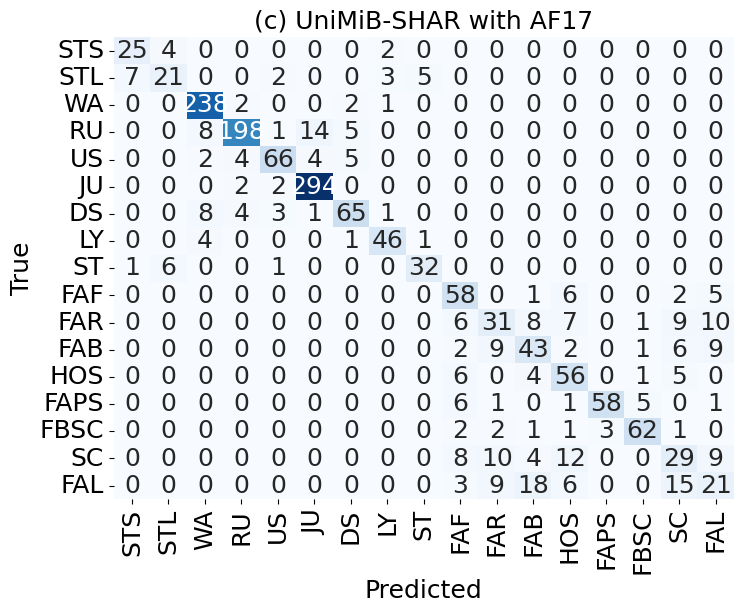

In [50]:
from sklearn.metrics import classification_report, accuracy_score
# Huấn luyện mô hình Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
n_estimators_= 36
max_depth_=16
random_state_=56
clf4 = RandomForestClassifier(criterion='entropy',n_jobs=-1, n_estimators=n_estimators_,ccp_alpha=0.0005, warm_start=False,
                                max_depth=max_depth_,max_features='sqrt',class_weight='balanced', 
                                bootstrap=True, random_state=random_state_).fit(train_features, label_train)
# Dự đoán trên tập test
predicted_RF = clf4.predict(test_features)
# Đánh giá mô hình
train_accuracy = clf4.score(train_features, label_train)
test_accuracy = clf4.score(test_features, label_test)
print(f"Accuracy of RF classifier on training set: {train_accuracy:.3f}")
print(f"Accuracy of RF classifier on test set: {test_accuracy:.3f}")
confusion_Rf =confusion_matrix(label_test, predicted_RF)
acc_names = scipy.io.loadmat(_dir+'UniMiB-SHAR/data/acc_names.mat')['acc_names']
labels = [name[0] for name in acc_names[1]]  # Chọn các tên hành động từ index 1
#['StandingUpFS', 'StandingUpFL', 'Walking', 'Running', 'GoingUpS', 'Jumping', 'GoingDownS', 'LyingDownFS', 'SittingDown', 'FallingForw', 'FallingRight', 'FallingBack', 'HittingObstacle', 'FallingWithPS', 'FallingBackSC', 'Syncope', 'FallingLeft']
labels1 = ['STS', 'STL', 'WA', 'RU', 'US', 'JU', 'DS', 'LY', 'ST', 'FAF', 'FAR', 'FAB', 'HOS', 'FAPS', 'FBSC', 'SC', 'FAL']
avg_accuracy, avg_sensitivity, avg_specificity, avg_precision,accuracy_total = calculate_metrics(confusion_Rf,labels)
print(
    f"accuracy:{avg_accuracy*100:.1f}  sensitivity:{avg_sensitivity*100:.1f}  "
    f"sensitivity:{avg_specificity*100:.1f}  precision:{avg_precision*100:.1f}"
     f"accuracy_total:{accuracy_total*100:.1f}  "
)
# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_Rf, annot=True, fmt="d", cmap="Blues", xticklabels=labels1, yticklabels=labels1,cbar=False, annot_kws={"size": 18})

# Set labels and title with font size 14
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.title('(c) UniMiB-SHAR with AF17', fontsize=18)
# Rotate x-axis labels by 20 degrees
plt.xticks(rotation=90, fontsize=18)
plt.yticks(rotation=0, fontsize=18)
# Show plot
plt.show()

Accuracy of RF classifier on test set: 94.3
accuracy:98.7  sensitivity:88.4  sensitivity:99.3  precision:90.1accuracy_total:98.7  


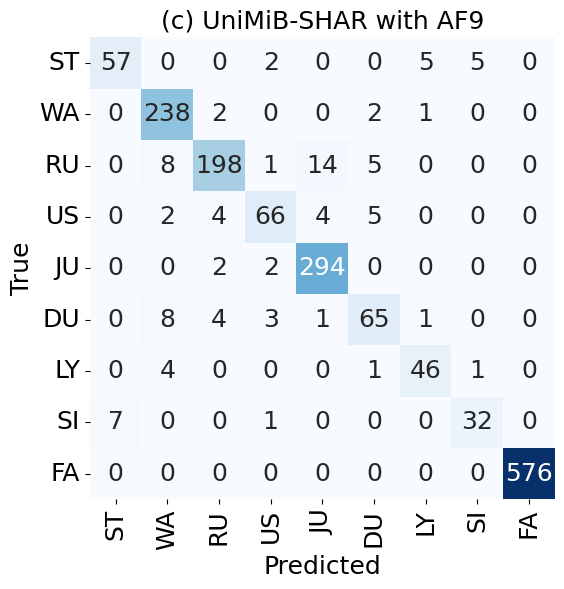

In [49]:
label_test_  = [0 if x == 1 else 9 if x in [9,10,11,12,13,14,15,16] else x for x in label_test]
labels_ = ['ST', 'WA', 'RU', 'US', 'JU', 'DU', 'LY', 'SI', 'FA'] #Standing, Walking, Running, UpStairs, Jumpping, Downstairs, Lying, Sitting, Falling
predicted_RF_ = [0 if x == 1 else 9 if x in [9,10,11,12,13,14,15,16] else x for x in predicted_RF]
confusion_rf_ =confusion_matrix(label_test_, predicted_RF_)

test_accuracy = f1_score(label_test_, predicted_RF_, average='micro') * 100  # F1 micro (%)
print(f"Accuracy of RF classifier on test set: {test_accuracy:.1f}")
avg_accuracy, avg_sensitivity, avg_specificity, avg_precision,accuracy_total = calculate_metrics(confusion_rf_,labels_)
print(
    f"accuracy:{avg_accuracy*100:.1f}  sensitivity:{avg_sensitivity*100:.1f}  "
    f"sensitivity:{avg_specificity*100:.1f}  precision:{avg_precision*100:.1f}"
     f"accuracy_total:{accuracy_total*100:.1f}  "
)
# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_rf_, annot=True, fmt="d", cmap="Blues", xticklabels=labels_, yticklabels=labels_, cbar=False, annot_kws={"size": 18})
# Set labels and title with font size 14
# Set labels and title with font size 14
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.title('(c) UniMiB-SHAR with AF9', fontsize=18)
# Rotate x-axis labels by 20 degrees
plt.xticks(rotation=90, fontsize=18)
plt.yticks(rotation=0, fontsize=18)
# Show plot
plt.show()

test_f1_score of RF classifier on test set: 100.0
accuracy:100.0  sensitivity:100.0  sensitivity:100.0  precision:100.0accuracy_total:100.0  


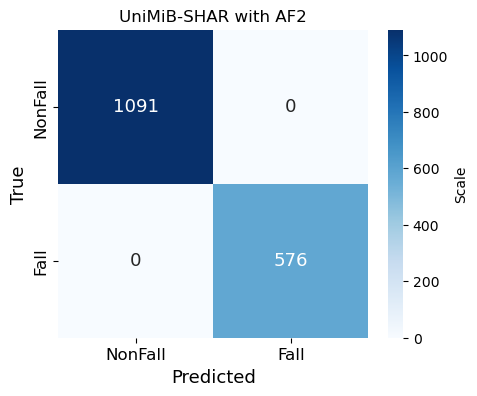

In [47]:
label_test__  = [0 if x in [0,1,2,3,4,5,6,7,8] else 9 if x in [9,10,11,12,13,14,15,16]  else x for x in label_test]
predicted_RF__ = [0 if x in [0,1,2,3,4,5,6,7,8] else 9 if x in [9,10,11,12,13,14,15,16]  else x for x in predicted_RF]
labels__ = ['NonFall', 'Fall'] #Standing, Walking, Running, UpStairs, Jumpping, Downstairs, Lying, Sitting, Falling

confusion_rf_ =confusion_matrix(label_test__, predicted_RF__)
test_f1_score = f1_score(label_test__, predicted_RF__, average='micro') * 100  # F1 micro (%)
print(f"test_f1_score of RF classifier on test set: {test_f1_score:.1f}")
avg_accuracy, avg_sensitivity, avg_specificity, avg_precision,accuracy_total = calculate_metrics(confusion_rf_,labels__)
print(
    f"accuracy:{avg_accuracy*100:.1f}  sensitivity:{avg_sensitivity*100:.1f}  "
    f"sensitivity:{avg_specificity*100:.1f}  precision:{avg_precision*100:.1f}"
     f"accuracy_total:{accuracy_total*100:.1f}  "
)
# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_rf_, annot=True, fmt="d", cmap="Blues", xticklabels=labels__, yticklabels=labels__, cbar_kws={'label': 'Scale'}, annot_kws={"size": 13})
# Set labels and title with font size 14
plt.xlabel('Predicted', fontsize=13)
plt.ylabel('True', fontsize=13)
plt.title('UniMiB-SHAR with AF2', fontsize=12)
# Rotate x-axis labels by 20 degrees
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Show plot
plt.show()

test_f1_score of RF classifier on test set: 93.6
accuracy:98.7  sensitivity:84.9  sensitivity:99.3  precision:86.6


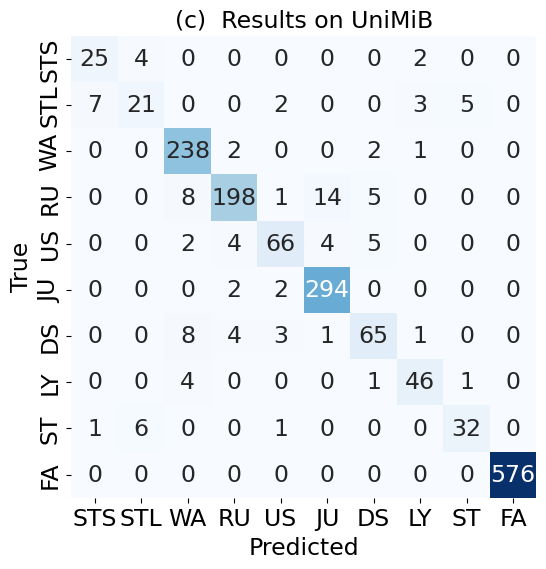

In [110]:
label_test3 = [ 9 if x in [9,10,11,12,13,14,15,16] else x for x in label_test]
predicted_RF3 = [ 9 if x in [9,10,11,12,13,14,15,16] else x for x in predicted_RF]
labels3= ['STS', 'STL', 'WA', 'RU', 'US', 'JU', 'DS', 'LY', 'ST', 'FA'] #Standing, Walking, Running, UpStairs, Jumpping, Downstairs, Lying, Sitting, Falling

confusion_rf_ =confusion_matrix(label_test3, predicted_RF3)
test_f1_score = f1_score(label_test3, predicted_RF3, average='micro') * 100  # F1 micro (%)
print(f"test_f1_score of RF classifier on test set: {test_f1_score:.1f}")
avg_accuracy, avg_sensitivity, avg_specificity, avg_precision,_ = calculate_metrics(confusion_rf_,labels3)
print(
    f"accuracy:{avg_accuracy*100:.1f}  sensitivity:{avg_sensitivity*100:.1f}  "
    f"sensitivity:{avg_specificity*100:.1f}  precision:{avg_precision*100:.1f}"
)
# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_rf_, annot=True, fmt="d", cmap="Blues", xticklabels=labels3, yticklabels=labels3, cbar=False, annot_kws={"size": 17})
# Set labels and title with font size 14
plt.xlabel('Predicted', fontsize=17)
plt.ylabel('True', fontsize=17)
plt.title('(c)  Results on UniMiB', fontsize=17)
# Rotate x-axis labels by 20 degrees
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
# Show plot
plt.show()

Xác thực chéo ngẫu nhiên 5 lần

In [72]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score
X_full = np.array(list(train_features)+list(test_features))
y_full = np.array(label_train+label_test)

kf_cv = KFold(n_splits=5, shuffle=True, random_state=1)

cv_train_accuracies = []
cv_test_accuracies = []
cv_conf_matrices = []

# Để lưu fold tốt nhất
best_fold_index = -1
best_test_acc = -1
best_conf_matrix = None
best_train_acc = -1
train_feature_= []
test_feature_=[]
label_train_=[]
label_test_=[]
mode_rf = 0
results_AF17=[]
results_AF10=[]
for fold_index, (cv_train_idx, cv_test_idx) in enumerate(kf_cv.split(X_full), start=1):
    _ktrain = X_full[cv_train_idx]
    _label_train = y_full[cv_train_idx]
    _ktest = X_full[cv_test_idx]
    _label_test = y_full[cv_test_idx]
    rf_cv_model = RandomForestClassifier(criterion='entropy',n_jobs=-1, n_estimators=n_estimators_,ccp_alpha=0.0005,
                                max_depth=max_depth_,max_features='sqrt',class_weight='balanced', 
                                bootstrap=True, random_state=random_state_).fit(_ktrain, _label_train)

    _pred_test = rf_cv_model.predict(_ktest)
    _pred_train = rf_cv_model.predict(_ktrain)
    label_test3 = [ 9 if x in [9,10,11,12,13,14,15,16] else x for x in _label_test]
    label_train3 = [ 9 if x in [9,10,11,12,13,14,15,16] else x for x in _label_train]
    _predicted_RF3 = [ 9 if x in [9,10,11,12,13,14,15,16] else x for x in _pred_test]
    _predicted_trainRF3 = [ 9 if x in [9,10,11,12,13,14,15,16] else x for x in _pred_train]
    
    labels3= ['ST1','ST2', 'WA', 'RU', 'US', 'JU', 'DU', 'LY', 'SI', 'FA'] #StandingUps, StandingUpFL, Walking, Running, UpStairs, Jumpping, Downstairs, Lying, Sitting, Falling
    f1score_train = rf_cv_model.score(_ktrain, _label_train)
    f1score_test = rf_cv_model.score(_ktest,_label_test)
    _matrix = confusion_matrix(_label_test, _pred_test)
     # Tính toán các chỉ số từ ma trận nhầm lẫn
    avg_accuracy, avg_sensitivity, avg_specificity, avg_precision,_ = calculate_metrics(_matrix,labels)


    # Tính F1-score (macro và micro) trên tập kiểm tra
    test_f1_macro = f1_score(_label_test, _pred_test, average='macro') * 100  # F1 macro (%)
    test_f1_micro = f1_score(_label_test, _pred_test, average='micro') * 100  # F1 micro (%)

    # Lưu kết quả
    results_AF17.append({
        'Fold': fold_index,
        # 'Model Size (Bytes)': model_size_in_bytes(rf_cv_model),
        'Accuracy (%)': round(avg_accuracy * 100, 1),  # Accuracy (%)
        'Sensitivity (%)': round(avg_sensitivity * 100, 1),  # Sensitivity (%)
        'Specificity (%)': round(avg_specificity * 100, 1),  # Specificity (%)
        'Precision (%)': round(avg_precision * 100, 1),  # Precision (%)
        'Train F1 Micro':round(f1score_train*100,1),
        'Test F1 Micro (%)': round(test_f1_micro, 1),
        'Test F1 Macro (%)': round(test_f1_macro, 1)
    })
    _matrix3 = confusion_matrix(label_test3, _predicted_RF3)
    # Tính toán các chỉ số từ ma trận nhầm lẫn
    avg_accuracy3, avg_sensitivity3, avg_specificity3, avg_precision3,_ = calculate_metrics(_matrix3,labels3)
    # Tính F1-score (macro và micro) trên tập kiểm tra
    test_f1_macro3 = f1_score(label_test3, _predicted_RF3, average='macro') * 100  # F1 macro (%)
    test_f1_micro3 = f1_score(label_test3, _predicted_RF3, average='micro') * 100  # F1 micro (%)
    f1score_train3 = accuracy_score( label_train3,_predicted_trainRF3)
    
    # Lưu kết quả
    results_AF10.append({
        'Fold': fold_index,
        # 'Model Size (Bytes)': model_size_in_bytes(rf_cv_model),
        'Accuracy (%)': round(avg_accuracy3 * 100, 1),  # Accuracy (%)
        'Sensitivity (%)': round(avg_sensitivity3 * 100, 1),  # Sensitivity (%)
        'Specificity (%)': round(avg_specificity3 * 100, 1),  # Specificity (%)
        'Precision (%)': round(avg_precision3 * 100, 1),  # Precision (%)
        'Train F1 Micro':round(f1score_train3*100,1),
        'Test F1 Micro (%)': round(test_f1_micro3, 1),
        'Test F1 Macro (%)': round(test_f1_macro3, 1)
    })    

    # Lưu lại fold tốt nhất nếu tốt hơn fold trước đó
    if f1score_test > best_test_acc:
        best_fold_index = fold_index
        best_test_acc = f1score_test
        best_train_acc = f1score_train
        best_conf_matrix = _matrix
        train_feature_= _ktrain
        test_feature_=_ktest
        label_train_=_label_train
        label_test_=_label_test
        mode_rf = rf_cv_model
    # Lưu để thống kê chung
    cv_train_accuracies.append(f1score_train)
    cv_test_accuracies.append(f1score_test)
    cv_conf_matrices.append(_matrix)

df_results_AF17 = pd.DataFrame(results_AF17)
# Tính trung bình các cột số học, bỏ qua cột 'Model'
mean_row = df_results_AF17.drop(columns=['Fold']).mean(numeric_only=True)
mean_row = mean_row.round(1)
# Chuyển thành dict và thêm cột 'Model' là 'Average'
mean_row_dict = {'Fold': 'Average'}
mean_row_dict.update(mean_row.to_dict())

# Thêm vào cuối danh sách kết quả
results_AF17.append(mean_row_dict)

df_results_AF17 = pd.DataFrame(results_AF17)

# ======
df_results_AF10 = pd.DataFrame(results_AF10)
# Tính trung bình các cột số học, bỏ qua cột 'Model'
mean_row3 = df_results_AF10.drop(columns=['Fold']).mean(numeric_only=True)
mean_row3 = mean_row3.round(1)
# Chuyển thành dict và thêm cột 'Model' là 'Average'
mean_row_dict3 = {'Fold': 'Average'}
mean_row_dict3.update(mean_row3.to_dict())

# Thêm vào cuối danh sách kết quả
results_AF10.append(mean_row_dict3)
df_results_AF10 = pd.DataFrame(results_AF10)

print("đánh giá AF17")
df_results_AF17

đánh giá AF17


,Fold,Accuracy (%),Sensitivity (%),Specificity (%),Precision (%),Train F1 Micro,Test F1 Micro (%),Test F1 Macro (%)
0,1,97.9,75.5,98.9,76.8,100.0,82.5,75.7
1,2,97.8,75.3,98.8,75.0,100.0,81.6,74.6
2,3,97.8,75.0,98.8,76.0,99.9,81.5,74.9
3,4,97.7,74.1,98.8,75.0,100.0,80.5,73.7
4,5,98.0,75.8,98.9,75.9,100.0,82.6,75.7
5,Average,97.8,75.1,98.8,75.7,100.0,81.7,74.9


In [73]:
print("đánh giá AF10")
df_results_AF10

đánh giá AF10


,Fold,Accuracy (%),Sensitivity (%),Specificity (%),Precision (%),Train F1 Micro,Test F1 Micro (%),Test F1 Macro (%)
0,1,99.1,87.5,99.5,90.4,100.0,95.3,88.8
1,2,98.9,87.7,99.4,88.6,100.0,94.6,87.7
2,3,98.9,87.5,99.4,89.9,99.9,94.4,88.3
3,4,98.7,85.7,99.3,86.1,100.0,93.4,85.1
4,5,98.9,87.7,99.4,88.9,100.0,94.4,88.3
5,Average,98.9,87.2,99.4,88.8,100.0,94.4,87.6


In [16]:
#k-folds AF17 voi cac models
import time
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
# import warnings
# warnings.filterwarnings("ignore")



# Gán lại để dễ dùng
data_full = np.array(list(train_features) + list(test_features))
label_full = np.array(label_train + label_test)

# KFold
kf_cv = KFold(n_splits=5, shuffle=True, random_state=1)

# Các mô hình (không thay đổi tham số)
models = [
    ('RF', RandomForestClassifier(criterion='entropy',n_jobs=-1, n_estimators=n_estimators_,
                                max_depth=max_depth_,max_features='sqrt',class_weight='balanced', 
                                bootstrap=True, random_state=random_state_)),
    ('XGBoost', xgb.XGBClassifier(n_estimators=n_estimators_, max_depth=12, learning_rate=0.05, random_state=random_state_)),
    ('DT', DecisionTreeClassifier(max_depth=18)),
    ('GBDT', GradientBoostingClassifier(learning_rate=0.05, n_estimators=18, max_depth=12, random_state=random_state_)),
    ('SVM', SVC(C=27, kernel='linear', random_state=random_state_, probability=False)),
    ('LightGBM', lgb.LGBMClassifier(n_estimators=18, max_depth=12, learning_rate=0.05, random_state=random_state_, verbose=-1))
]

final_results = []
total_model = {}
for model_name, model_ in models:
    nameModel,size_model,acc_list, sens_list, spec_list, prec_list = [],[], [], [], [],[]
    train_f1_micro_list, test_f1_micro_list, test_f1_macro_list, auc_list = [], [], [], []
    
    for train_index, test_index in kf_cv.split(data_full):
        fold_train, fold_test = data_full[train_index], data_full[test_index]
        label_fold_train, label_fold_test = label_full[train_index], label_full[test_index]
        
        model_.fit(fold_train, label_fold_train)
        y_pred = model_.predict(fold_test)
        
        cm = confusion_matrix(label_fold_test, y_pred)
        avg_accuracy, avg_sensitivity, avg_specificity, avg_precision, _ = calculate_metrics(cm, labels)

        # F1 and AUC
        nameModel.append(model_name)
        size_model.append(model_size_in_bytes(model_))
        f1_micro_train = round(f1_score(label_fold_train, model_.predict(fold_train), average='micro') * 100, 1)
        f1_micro_test = round(f1_score(label_fold_test, y_pred, average='micro') * 100, 1)
        f1_macro_test = round(f1_score(label_fold_test, y_pred, average='macro') * 100, 1)
        avg_accuracy = round(avg_accuracy * 100, 1)
        avg_sensitivity = round(avg_sensitivity * 100, 1)
        avg_specificity = round(avg_specificity * 100, 1)
        avg_precision = round(avg_precision * 100, 1)
        acc_list.append(avg_accuracy)
        sens_list.append(avg_sensitivity)
        spec_list.append(avg_specificity)
        prec_list.append(avg_precision)
        train_f1_micro_list.append(f1_micro_train)
        test_f1_micro_list.append(f1_micro_test)
        test_f1_macro_list.append(f1_macro_test)
    # Sau khi tính xong các metrics từng fold
    final_results.append({
        'Model': model_name,
        'Model Size (Bytes)': round(np.mean(size_model), 1),
        'Accuracy (%)': round(np.mean(acc_list), 1),
        'Sensitivity (%)': round(np.mean(sens_list), 1),
        'Specificity (%)': round(np.mean(spec_list), 1),
        'Precision (%)': round(np.mean(prec_list), 1),
        'Train F1 Micro (%)': round(np.mean(train_f1_micro_list), 1),
        'Test F1 Micro (%)': round(np.mean(test_f1_micro_list), 1),
        'Test F1 Macro (%)': round(np.mean(test_f1_macro_list), 1),
    })
    if model_name == "SVM":
        print("1 lan SVM")
    total_model[model_name] = {
        'Model': nameModel.copy(),
        'Model Size (Bytes)': size_model.copy(),
        'Accuracy (%)': acc_list.copy(),
        'Sensitivity (%)': sens_list.copy(),
        'Specificity (%)': spec_list.copy(),
        'Precision (%)': prec_list.copy(),
        'Train F1 Micro (%)': train_f1_micro_list.copy(),
        'Test F1 Micro (%)': test_f1_micro_list.copy(),
        'Test F1 Macro (%)': test_f1_macro_list.copy()
    }
    

# Xuất kết quả
results_model = pd.DataFrame(final_results)
results_model


1 lan SVM


,Model,Model Size (Bytes),Accuracy (%),Sensitivity (%),Specificity (%),Precision (%),Train F1 Micro (%),Test F1 Micro (%),Test F1 Macro (%)
0,RF,7003691.2,97.9,75.2,98.9,76.0,100.0,81.9,75.1
1,XGBoost,1608902.0,97.8,75.0,98.9,75.6,99.5,81.7,74.8
2,DT,196138.8,96.7,63.3,98.2,63.6,99.6,71.9,62.9
3,GBDT,14195153.8,96.6,60.6,98.1,68.6,100.0,71.2,63.4
4,SVM,699514.6,97.4,70.0,98.6,71.9,81.8,77.7,70.2
5,LightGBM,1039277.8,97.7,73.4,98.8,75.5,98.9,80.8,73.9


In [86]:
#k-folds AF10 voi cac models
import time
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
# import warnings
# warnings.filterwarnings("ignore")

# Gán lại để dễ dùng
data_full = np.array(list(train_features) + list(test_features))
label_full = np.array(label_train + label_test)
# KFold
# KFold
kf_cv = KFold(n_splits=5, shuffle=True, random_state=1)

# Các mô hình (không thay đổi tham số)
models = [
    ('RF', RandomForestClassifier(criterion='entropy',n_jobs=-1, n_estimators=n_estimators_,ccp_alpha=0.0005,
                                max_depth=max_depth_,max_features='sqrt',class_weight='balanced', 
                                bootstrap=True, random_state=random_state_)),
    ('XGBoost', xgb.XGBClassifier(n_estimators=n_estimators_, max_depth=12, learning_rate=0.05, random_state=random_state_)),
    ('DT', DecisionTreeClassifier(max_depth=18)),
    ('GBDT', GradientBoostingClassifier(learning_rate=0.05, n_estimators=18, max_depth=12, random_state=random_state_)),
    ('SVM', SVC(C=27, kernel='linear', random_state=random_state_, probability=False)),
    ('LightGBM', lgb.LGBMClassifier(n_estimators=18, max_depth=12, learning_rate=0.05, random_state=random_state_, verbose=-1))
]

final_resultsML = []
total_modelML = {}
for model_name, model_ in models:
    nameModel,size_model,acc_list, sens_list, spec_list, prec_list = [],[], [], [], [],[]
    train_f1_micro_list, test_f1_micro_list, test_f1_macro_list, auc_list = [], [], [], []
    
    for train_index, test_index in kf_cv.split(data_full):
        fold_train, fold_test = data_full[train_index], data_full[test_index]
        label_fold_train, label_fold_test = label_full[train_index], label_full[test_index]
        label_test3 = [ 9 if x in [9,10,11,12,13,14,15,16] else x for x in label_fold_test]
        label_train3 = [ 9 if x in [9,10,11,12,13,14,15,16] else x for x in label_fold_train]
        model_.fit(fold_train, label_fold_train)
        pred_test = model_.predict(fold_test)
        pred_train = model_.predict(fold_train)
        
        label_test3 = [ 9 if x in [9,10,11,12,13,14,15,16] else x for x in label_fold_test]
        label_train3 = [ 9 if x in [9,10,11,12,13,14,15,16] else x for x in label_fold_train]
        _pred_test = [ 9 if x in [9,10,11,12,13,14,15,16] else x for x in pred_test]
        _pred_train = [ 9 if x in [9,10,11,12,13,14,15,16] else x for x in pred_train]
        labels3= ['ST1','ST2', 'WA', 'RU', 'US', 'JU', 'DU', 'LY', 'SI', 'FA'] #StandingUps, StandingUpFL, Walking, Running, UpStairs, Jumpping, Downstairs, Lying, Sitting, Falling
        
        _matrix_test = confusion_matrix(label_test3, _pred_test)
        
        # Tính toán các chỉ số từ ma trận nhầm lẫn
        avg_accuracy, avg_sensitivity, avg_specificity, avg_precision, _ = calculate_metrics(_matrix_test, labels3)

        # F1 and AUC
        nameModel.append(model_name)
        size_model.append(model_size_in_bytes(model_))
        f1_micro_train = round(f1_score(label_train3, _pred_train, average='micro') * 100, 1)
        f1_micro_test = round(f1_score(label_test3, _pred_test, average='micro') * 100, 1)
        f1_macro_test = round(f1_score(label_test3, _pred_test, average='macro') * 100, 1)
        avg_accuracy = round(avg_accuracy * 100, 1)
        avg_sensitivity = round(avg_sensitivity * 100, 1)
        avg_specificity = round(avg_specificity * 100, 1)
        avg_precision = round(avg_precision * 100, 1)
        acc_list.append(avg_accuracy)
        sens_list.append(avg_sensitivity)
        spec_list.append(avg_specificity)
        prec_list.append(avg_precision)
        train_f1_micro_list.append(f1_micro_train)
        test_f1_micro_list.append(f1_micro_test)
        test_f1_macro_list.append(f1_macro_test)
    # Sau khi tính xong các metrics từng fold
    final_resultsML.append({
        'Model': model_name,
        'Model Size (Bytes)': round(np.mean(size_model), 1),
        'Accuracy (%)': round(np.mean(acc_list), 1),
        'Sensitivity (%)': round(np.mean(sens_list), 1),
        'Specificity (%)': round(np.mean(spec_list), 1),
        'Precision (%)': round(np.mean(prec_list), 1),
        'Train F1 Micro (%)': round(np.mean(train_f1_micro_list), 1),
        'Test F1 Micro (%)': round(np.mean(test_f1_micro_list), 1),
        'Test F1 Macro (%)': round(np.mean(test_f1_macro_list), 1),
    })
    if model_name == "SVM":
        print("1 lan SVM")
    total_modelML[model_name] = {
        'Model': nameModel.copy(),
        'Model Size (Bytes)': size_model.copy(),
        'Accuracy (%)': acc_list.copy(),
        'Sensitivity (%)': sens_list.copy(),
        'Specificity (%)': spec_list.copy(),
        'Precision (%)': prec_list.copy(),
        'Train F1 Micro (%)': train_f1_micro_list.copy(),
        'Test F1 Micro (%)': test_f1_micro_list.copy(),
        'Test F1 Macro (%)': test_f1_macro_list.copy()
    }
    
print("kfolds voi Af10")
# Xuất kết quả
results_modelML = pd.DataFrame(final_resultsML)
results_modelML


1 lan SVM
kfolds voi Af10


,Model,Model Size (Bytes),Accuracy (%),Sensitivity (%),Specificity (%),Precision (%),Train F1 Micro (%),Test F1 Micro (%),Test F1 Macro (%)
0,RF,6267479.0,98.9,87.2,99.4,88.8,100.0,94.4,87.6
1,XGBoost,1608902.0,98.8,86.0,99.3,87.2,99.6,94.0,86.3
2,DT,196218.8,97.8,78.2,98.8,78.4,100.0,89.1,77.8
3,GBDT,14195153.8,96.6,72.9,98.0,80.8,100.0,83.0,75.4
4,SVM,699514.6,98.2,80.0,99.0,83.1,93.7,91.1,80.7
5,LightGBM,1039277.8,98.6,84.2,99.2,87.3,99.2,93.0,85.3


In [104]:
#đọc va ghi dữ liệu
try:
#Ghi kết quả vào file CSV
    # joblib.dump(data_train, save_+'data_train.pkl')
    # joblib.dump(data_test, save_+'data_test.pkl')
    # joblib.dump(train_features, save_+'UniMiB_train_features.pkl')
    # joblib.dump(test_features, save_+'UniMiB_test_features.pkl')
    # joblib.dump(label_test, save_+'UniMiB_label_test.pkl')
    # joblib.dump(label_train, save_+'UniMiB_label_train.pkl')
    # joblib.dump(clf4, save_+'clf4.pkl')
    # joblib.dump(best_params, save_+'best_params.pkl')
    # joblib.dump(total_model, save_+'total_model.pkl')
    # joblib.dump(total_modelML, save_+'total_modelML.pkl')
    # joblib.dump(total_model, save_+'total_model.pkl')
    # joblib.dump(results_modelML, save_+'results_modelML.pkl')
    # results_df.to_csv(save_+"results_modelUniMiB.csv", index=False)
    print("Kết quả đã được ghi thành công vào file CSV.")
except Exception as e:
    print(f"Không thể ghi file CSV. Lỗi: {e}")


# data_train = joblib.load(save_ + 'data_train.pkl')
# data_test = joblib.load(save_ + 'data_test.pkl')
# train_features = joblib.load(save_ + 'UniMiB_train_features.pkl')
# test_features = joblib.load(save_ + 'UniMiB_test_features.pkl')
# label_train = joblib.load(save_ + 'UniMiB_label_train.pkl')
# label_test = joblib.load(save_ + 'UniMiB_label_test.pkl')
# clf4 = joblib.load(save_ + 'clf4.pkl')
# # best_params = joblib.load(save_ + 'best_params.pkl')
# total_model = joblib.load(save_ + 'total_model.pkl')

Kết quả đã được ghi thành công vào file CSV.


In [68]:
#paper: Channel Attention for Sensor-Based Activity ecognition: Embedding Features into all Frequencies in DCT Domain
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
labels1=['STS', 'STL', 'WA', 'RU', 'US', 'JU', 'DS', 'LY', 'ST', 'FAF', 'FAR', 'FAB', 'HOS', 'FAPS', 'FBSC', 'SC', 'FAL']
# Confusion matrix extracted from the image
confusionmatrix = np.array([
    [24, 19, 0,   0, 0, 0, 0,  7, 1,0, 0, 0, 0, 1 , 3, 0, 0],
    [4,  49, 0,   0, 2, 0, 0,  9, 3, 0, 0, 0, 0, 0, 5, 0, 0],
    [0,  0,  551, 3, 5, 0, 9,   0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0,  0,  5, 618, 0, 4, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0,  2,  8,   1, 289, 0, 2, 3, 0, 0, 0, 6, 0, 0, 0, 0, 0],
    [0,  0,  0,   0,  0,  254, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 20, 4, 0, 436, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 19, 0, 0, 2, 0, 0, 68, 7, 0, 1, 0, 1, 0, 4, 0, 2],
    [1, 0, 0, 0, 0, 0, 0, 9, 56, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 1, 187, 3, 7, 0, 1, 0, 3, 5],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 91, 6, 11, 11, 9, 11, 23],
    [0, 0, 0, 0, 0, 3, 0, 0, 0, 10, 17, 84, 10, 6, 21, 1, 36],
    [0, 2, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 196, 2, 2, 4, 5],
    [0, 5, 0, 0, 0, 1, 0, 0, 0, 59, 3, 1, 1, 85, 2, 2, 4],
    [1, 0, 0, 0, 0, 0, 2, 3, 1, 4, 14, 31, 3, 5, 60, 8, 15],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 35, 3, 18, 9, 6, 69, 27],
    [0, 2, 0, 0, 0, 0, 0, 2, 1, 9, 7, 34, 5, 7, 10, 7, 101]])

labels1=['STS', 'STL', 'WA', 'RU', 'US', 'JU', 'DS', 'LY', 'ST', 'FAF', 'FAR', 'FAB', 'HOS', 'FAPS', 'FBSC', 'SC', 'FAL']

y_true = []
y_pred = []

for true_label, row in enumerate(confusionmatrix):
    for pred_label, count in enumerate(row):
        y_true += [true_label] * count
        y_pred += [pred_label] * count

from sklearn.metrics import confusion_matrix

# Recalculate confusion matrix to ensure shape and consistency
cm = confusion_matrix(y_true, y_pred)

avg_accuracy, avg_sensitivity, avg_specificity, avg_precision,accuracy_total= calculate_metrics(cm,labels1)
# F1-score with micro average
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_macro = f1_score(y_true, y_pred, average='macro')
print(f"AF17: Accuracy: {avg_accuracy:.1%} | Sensitivity: {avg_sensitivity:.1%} | Specificity: {avg_specificity:.1%} |"
      f"Precision: {avg_precision:.1%} | f1_micro: {f1_micro:.1%}| f1_macro: {f1_macro:.1%}")


label_3 = [ 9 if x in [9,10,11,12,13,14,15,16] else x for x in y_true]
predicted_3 = [ 9 if x in [9,10,11,12,13,14,15,16] else x for x in y_pred]
labels3= ['STS', 'STL', 'WA', 'RU', 'US', 'JU', 'DS', 'LY', 'ST', 'FA'] #Standing, Walking, Running, UpStairs, Jumpping, Downstairs, Lying, Sitting, Falling

cm3 = confusion_matrix(label_3, predicted_3)

avg_accuracy, avg_sensitivity, avg_specificity, avg_precision,accuracy_total = calculate_metrics(cm3,labels3)

# F1-score with micro average
f1_micro = f1_score(label_3, predicted_3, average='micro')
f1_macro = f1_score(label_3, predicted_3, average='macro')
print(f"AF10: Accuracy: {avg_accuracy:.1%} | Sensitivity: {avg_sensitivity:.1%} | Specificity: {avg_specificity:.1%} |"
      f"Precision: {avg_precision:.1%} | f1_micro: {f1_micro:.1%}| f1_macro: {f1_macro:.1%}")


label_2  = [0 if x in [0,1,2,3,4,5,6,7,8] else 9 if x in [9,10,11,12,13,14,15,16]  else x for x in y_true]
predicted_2= [0 if x in [0,1,2,3,4,5,6,7,8] else 9 if x in [9,10,11,12,13,14,15,16]  else x for x in y_pred]
labels__ = ['NonFall', 'Fall']
cm2 = confusion_matrix(label_2, predicted_2)
avg_accuracy, avg_sensitivity, avg_specificity, avg_precision,accuracy_total = calculate_metrics(cm2,labels__)
# F1-score with micro average
f1_micro = f1_score(label_2, predicted_2, average='micro')
f1_macro = f1_score(label_2, predicted_2, average='macro')
print(f"AF2: Accuracy: {avg_accuracy:.1%} | Sensitivity: {avg_sensitivity:.1%} | Specificity: {avg_specificity:.1%} |"
      f"Precision: {avg_precision:.1%} | f1_micro: {f1_micro:.1%}| f1_macro: {f1_macro:.1%}")


AF17: Accuracy: 97.6% | Sensitivity: 70.2% | Specificity: 98.7% |Precision: 71.7% | f1_micro: 79.7%| f1_macro: 70.0%
AF10: Accuracy: 98.9% | Sensitivity: 83.6% | Specificity: 99.4% |Precision: 85.2% | f1_micro: 94.3%| f1_macro: 83.7%
AF2: Accuracy: 98.7% | Sensitivity: 98.6% | Specificity: 98.6% |Precision: 98.6% | f1_micro: 98.7%| f1_macro: 98.6%


In [66]:
#paper: Innovative Dual-Decoupling CNN With Layer-Wise Temporal-Spatial Attention for Sensor-Based Human Activity Recognition
from sklearn.metrics import accuracy_score, f1_score
confusionmatrix = np.array([
    [ 17,  27,   0,   0,   0,   0,   0,   6,   0,   0,   0,   1,   0,   2,   2,   0,   0],
    [  3,  60,   0,   0,   0,   0,   0,   8,   1,   0,   0,   0,   0,   0,   0,   0,   0],
    [  0,   0, 560,   0,   2,   0,   6,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
    [  0,   0,   6, 609,   0,   0,  36,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
    [  0,   6,  12,   0, 276,   1,  13,   0,   0,   0,   0,   0,   0,   0,   0,   2,   1],
    [  0,   0,   0,   0,   0, 254,   2,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0],
    [  0,   1,  12,  11,   1,   0, 439,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0],
    [  0,  33,   0,   0,   0,   0,   0,  62,   5,   0,   1,   1,   0,   0,   0,   2,   0],
    [  0,   7,   0,   0,   0,   0,   0,  20,  39,   0,   0,   0,   0,   1,   0,   0,   0],
    [  0,   1,   0,   0,   0,   0,   0,   0,   0, 159,   3,   2,   0,  29,   0,  10,   5],
    [  0,   0,   0,   0,   0,   0,   0,   2,   0,  26, 104,  16,   5,   3,   0,  14,   6],
    [  0,   0,   0,   0,   0,   1,   0,   1,   0,  11,  29,  94,   5,   9,  22,  13,   3],
    [  0,   1,   0,   0,   0,   0,   0,   5,   0,   9,  14,  24, 157,   8,   1,  14,   0],
    [  0,   5,   0,   0,   0,   0,   0,   2,   0,  54,   8,   0,   1,  85,   0,   6,   2],
    [  1,   2,   1,   0,   0,   0,   0,   3,   0,   1,  12,  53,   1,   0,  63,   6,   4],
    [  0,   0,   0,   0,   0,   0,   0,   0,   0,  17,  50,  10,   9,   6,   6,  49,  39],
    [  0,   0,   0,   0,   0,   0,   0,   0,   0,   7,  13,  47,   2,   14,  6,  32,  64],
])
labels1=['STS', 'STL', 'WA', 'RU', 'US', 'JU', 'DS', 'LY', 'ST', 'FAF', 'FAR', 'FAB', 'HOS', 'FAPS', 'FBSC', 'SC', 'FAL']

y_true = []
y_pred = []

for true_label, row in enumerate(confusionmatrix):
    for pred_label, count in enumerate(row):
        y_true += [true_label] * count
        y_pred += [pred_label] * count

from sklearn.metrics import confusion_matrix

# Recalculate confusion matrix to ensure shape and consistency
cm = confusion_matrix(y_true, y_pred)

avg_accuracy, avg_sensitivity, avg_specificity, avg_precision,accuracy_total= calculate_metrics(cm,labels1)
# F1-score with micro average
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_macro = f1_score(y_true, y_pred, average='macro')
print(f"AF17: Accuracy: {avg_accuracy:.1%} | Sensitivity: {avg_sensitivity:.1%} | Specificity: {avg_specificity:.1%} |"
      f"Precision: {avg_precision:.1%} | f1_micro: {f1_micro:.1%}| f1_macro: {f1_macro:.1%}")


label_3 = [ 9 if x in [9,10,11,12,13,14,15,16] else x for x in y_true]
predicted_3 = [ 9 if x in [9,10,11,12,13,14,15,16] else x for x in y_pred]
labels3= ['STS', 'STL', 'WA', 'RU', 'US', 'JU', 'DS', 'LY', 'ST', 'FA'] #Standing, Walking, Running, UpStairs, Jumpping, Downstairs, Lying, Sitting, Falling

cm3 = confusion_matrix(label_3, predicted_3)

avg_accuracy, avg_sensitivity, avg_specificity, avg_precision,accuracy_total = calculate_metrics(cm3,labels3)

# F1-score with micro average
f1_micro = f1_score(label_3, predicted_3, average='micro')
f1_macro = f1_score(label_3, predicted_3, average='macro')
print(f"AF10: Accuracy: {avg_accuracy:.1%} | Sensitivity: {avg_sensitivity:.1%} | Specificity: {avg_specificity:.1%} |"
      f"Precision: {avg_precision:.1%} | f1_micro: {f1_micro:.1%}| f1_macro: {f1_macro:.1%}")


label_2  = [0 if x in [0,1,2,3,4,5,6,7,8] else 9 if x in [9,10,11,12,13,14,15,16]  else x for x in y_true]
predicted_2= [0 if x in [0,1,2,3,4,5,6,7,8] else 9 if x in [9,10,11,12,13,14,15,16]  else x for x in y_pred]
labels__ = ['NonFall', 'Fall']
cm2 = confusion_matrix(label_2, predicted_2)
avg_accuracy, avg_sensitivity, avg_specificity, avg_precision,accuracy_total = calculate_metrics(cm2,labels__)
# F1-score with micro average
f1_micro = f1_score(label_2, predicted_2, average='micro')
f1_macro = f1_score(label_2, predicted_2, average='macro')
print(f"AF2: Accuracy: {avg_accuracy:.1%} | Sensitivity: {avg_sensitivity:.1%} | Specificity: {avg_specificity:.1%} |"
      f"Precision: {avg_precision:.1%} | f1_micro: {f1_micro:.1%}| f1_macro: {f1_macro:.1%}")


AF17: Accuracy: 97.2% | Sensitivity: 65.6% | Specificity: 98.5% |Precision: 69.0% | f1_micro: 76.6%| f1_macro: 65.5%
AF10: Accuracy: 98.7% | Sensitivity: 80.5% | Specificity: 99.3% |Precision: 84.5% | f1_micro: 93.6%| f1_macro: 80.3%
AF2: Accuracy: 99.0% | Sensitivity: 98.9% | Specificity: 98.9% |Precision: 99.0% | f1_micro: 99.0%| f1_macro: 98.9%


In [90]:
total_model

{'RF': {'Model': ['RF', 'RF', 'RF', 'RF', 'RF'],
  'Model Size (Bytes)': [7109009, 6978964, 7153027, 6817319, 6960137],
  'Accuracy (%)': [98.0, 97.8, 97.8, 97.7, 98.0],
  'Sensitivity (%)': [75.6, 75.3, 74.9, 74.4, 75.8],
  'Specificity (%)': [98.9, 98.9, 98.8, 98.8, 98.9],
  'Precision (%)': [77.3, 75.2, 75.8, 75.6, 76.0],
  'Train F1 Micro (%)': [100.0, 100.0, 100.0, 100.0, 100.0],
  'Test F1 Micro (%)': [82.9, 81.7, 81.3, 80.8, 82.6],
  'Test F1 Macro (%)': [76.0, 74.7, 74.7, 74.2, 75.7]},
 'XGBoost': {'Model': ['XGBoost', 'XGBoost', 'XGBoost', 'XGBoost', 'XGBoost'],
  'Model Size (Bytes)': [1610930, 1614395, 1614870, 1592835, 1611480],
  'Accuracy (%)': [98.0, 97.7, 97.9, 97.8, 97.8],
  'Sensitivity (%)': [75.5, 74.3, 75.9, 75.3, 73.9],
  'Specificity (%)': [99.0, 98.8, 98.9, 98.8, 98.8],
  'Precision (%)': [77.3, 73.7, 77.1, 75.8, 73.9],
  'Train F1 Micro (%)': [99.5, 99.5, 99.5, 99.6, 99.6],
  'Test F1 Micro (%)': [83.4, 80.7, 82.2, 81.1, 81.3],
  'Test F1 Macro (%)': [76.1, 73.

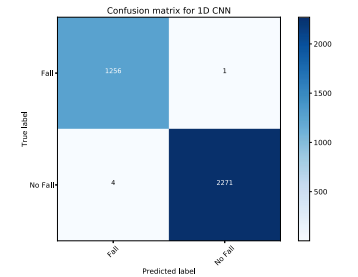

In [67]:
#TheFutureofHumanActivityRecognition: DeepLearningor Feature Engineering
confusionmatrix = np.array([
    [ 1256,  1  ],
    [  4,  2271 ]])
y_true = []
y_pred = []

for true_label, row in enumerate(confusionmatrix):
    for pred_label, count in enumerate(row):
        y_true += [true_label] * count
        y_pred += [pred_label] * count
        
labels__ = ['NonFall', 'Fall']
cm2 = confusion_matrix(y_true, y_pred)
avg_accuracy, avg_sensitivity, avg_specificity, avg_precision,accuracy_total = calculate_metrics(cm2,labels__)
# F1-score with micro average
f1_micro = f1_score(label_2, predicted_2, average='micro')
f1_macro = f1_score(label_2, predicted_2, average='macro')
print(f"AF2: Accuracy: {avg_accuracy:.1%} | Sensitivity: {avg_sensitivity:.1%} | Specificity: {avg_specificity:.1%} |"
      f"Precision: {avg_precision:.1%} | f1_micro: {f1_micro:.1%}| f1_macro: {f1_macro:.1%}")


AF2: Accuracy: 99.9% | Sensitivity: 99.9% | Specificity: 99.9% |Precision: 99.8% | f1_micro: 99.0%| f1_macro: 98.9%
